In [0]:
from pyspark.sql import SparkSession

#create a session

ss = SparkSession.builder.appName("Retail Banking Spark Project").getOrCreate()

In [0]:
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DateType, DecimalType, BooleanType, TimestampType, ShortType, VarcharType, CharType

In [0]:
from pyspark.sql.functions import col, sum, avg, row_number, when, trim, lit

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
ss

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
#create schemas for all 12 csv files so the datatype stays consistent or error if inconsistent.

#1
accounts_schema = StructType([
    StructField("account_id", StringType(), True),
    StructField("district_id", IntegerType(), True),
    StructField("frequency", StringType(), True),
    StructField("parseddate", DateType(), True),
    StructField("year", IntegerType(), True),   
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("date", DateType(), True)
])
#2
cards_schema = StructType([
    StructField("card_id", StringType(), True),
    StructField("disp_id", StringType(), True),
    StructField("type", StringType(), True),
    StructField("year", IntegerType(), True),   
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("fulldate", DateType(), True)
])
#3
clients_schema = StructType([
    StructField("client_id", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("fulldate", DateType(), True),
    StructField("day", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("year", IntegerType(), True),  
    StructField("date", DateType(), True),
    StructField("age", ShortType(), True),
    StructField("social", StringType(), True),
    StructField("first", StringType(), True),
    StructField("middle", StringType(), True),
    StructField("last", StringType(), True),
    StructField("phone", StringType(), True),
    StructField("email", StringType(), True),
    StructField("address_1", StringType(), True),
    StructField("address_2", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zipcode", IntegerType(), True),
    StructField("district_id", IntegerType(), True)
])
#4
dispositions_schema = StructType([
    StructField("disp_id",StringType(),True),
    StructField("client_id",StringType(),True),
    StructField("account_id",StringType(),True),
    StructField("type",StringType(),True)
])

#5
districts_schema = StructType([
    StructField("district_id", IntegerType(), True),
    StructField("city", StringType(), True),
    StructField("state_name", StringType(), True),
    StructField("state_abbrev", StringType(), True),
    StructField("region", StringType(), True),
    StructField("division", StringType(), True)
])

#6
loans_schema = StructType([
    StructField("loan_id", DecimalType(10, 2), True), 
    StructField("account_id", StringType(), True),
    StructField("amount", IntegerType(), True),
    StructField("duration", IntegerType(), True),
    StructField("payments", IntegerType(), True),
    StructField("status", StringType(), True),
    StructField("year", IntegerType(), True),  
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("fulldate", DateType(), True),
    StructField("location", IntegerType(), True),
    StructField("purpose", StringType(), True)
])

#7
orders_schema = StructType([
    StructField("order_id", IntegerType(), True),
    StructField("account_id", StringType(), True),
    StructField("bank_to", StringType(), True),
    StructField("account_to", IntegerType(), True),
    StructField("amount", DecimalType(10, 2), True),
    StructField("k_symbol", StringType(), True)
])

#8
transactions_schema = StructType([
    StructField("column_a", IntegerType(), True),
    StructField("trans_id", StringType(), True),
    StructField("account_id", StringType(), True),
    StructField("type", StringType(), True),
    StructField("operation", StringType(), True),
    StructField("amount", DecimalType(10, 2), True),  
    StructField("balance", DecimalType(10, 2), True), 
    StructField("k_symbol", StringType(), True),
    StructField("bank", StringType(), True),
    StructField("account", IntegerType(), True),
    StructField("year", IntegerType(), True),        
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("fulldate", DateType(), True),
    StructField("fulltime", StringType(), True),
    StructField("fulldatewithtime", StringType(), True)
])

#9
crm_call_center_logs_schema = StructType([
    StructField("date_received", DateType(), True),
    StructField("complaint_id", StringType(), True),
    StructField("rand_client", StringType(), True),  
    StructField("phonefinal", StringType(), True),
    StructField("vru_line", StringType(), True),
    StructField("call_id", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("outcome", StringType(), True),
    StructField("server", StringType(), True),
    StructField("ser_start", TimestampType(), True),       #double check. only time format present: 00:00:00
    StructField("ser_exit", TimestampType(), True),
    StructField("ser_time", TimestampType(), True)
])

#10
crm_events_schema = StructType([
    StructField("date_received", DateType(), True),
    StructField("product", StringType(), True),
    StructField("sub_product", StringType(), True),
    StructField("issue", StringType(), True),
    StructField("sub_issue", StringType(), True),
    StructField("consumer_complaint_narrative", StringType(), True),
    StructField("tags", StringType(), True),
    StructField("consumer_consent_provided", StringType(), True),
    StructField("submitted_via", StringType(), True),
    StructField("date_sent_to_company", DateType(), True),
    StructField("company_response_to_consumer", StringType(), True),
    StructField("timely_response", StringType(), True),
    StructField("consumer_disputed", StringType(), True),
    StructField("complaint_id", StringType(), True),
    StructField("client_id", StringType(), True)     
])

#11
crm_reviews_schema = StructType([
    StructField("date", DateType(), True),
    StructField("stars", IntegerType(), True),
    StructField("reviews", StringType(), True),
    StructField("product", StringType(), True),
    StructField("district_id", IntegerType(), True)
])

#12
luxury_loan_portfolio_schema = StructType([
    StructField("loan_id", StringType(), True),
    StructField("funded_amount", DecimalType(10, 2), True),          
    StructField("funded_date", DateType(), True),
    StructField("duration_years", IntegerType(), True),
    StructField("duration_months", IntegerType(), True),
    StructField("10_yr_treasury_index_date_funded", DecimalType(10, 2), True), 
    StructField("interest_rate_percent", DecimalType(5, 2), True),      #decimaltype(5,2) to represent percentage
    StructField("interest_rate", DecimalType(10, 2), True),            
    StructField("payments", DecimalType(10, 2), True),
    StructField("total_past_payments", IntegerType(), True),
    StructField("loan_balance", DecimalType(10, 2), True),
    StructField("property_value", DecimalType(10, 2), True),
    StructField("purpose", StringType(), True),
    StructField("firstname", StringType(), True),
    StructField("middlename", StringType(), True),
    StructField("lastname", StringType(), True),
    StructField("social", StringType(), True),
    StructField("phone", StringType(), True),
    StructField("title", StringType(), True),
    StructField("employment_length", IntegerType(), True),
    StructField("building_class_category", StringType(), True),
    StructField("tax_class_at_present", StringType(), True),
    StructField("building_class_at_present", StringType(), True),
    StructField("address_1", StringType(), True),
    StructField("address_2", StringType(), True),
    StructField("zip_code", IntegerType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("total_units", IntegerType(), True),
    StructField("land_square_feet", IntegerType(), True),
    StructField("gross_square_feet", IntegerType(), True),
    StructField("tax_class_at_time_of_sale", IntegerType(), True)
])

In [0]:
accounts_df = ss.read.schema(accounts_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedacct.csv")

cards_df = ss.read.schema(cards_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedcard.csv")

clients_df_schema = ss.read.schema(clients_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedclient.csv")
#not using the schema was more efficient to keep data integrity for clients_df
clients_df = ss.read.format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedclient.csv")

dispositions_df = ss.read.schema(dispositions_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completeddisposition.csv")

districts_df = ss.read.schema(districts_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completeddistrict.csv")

loans_df = ss.read.schema(loans_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedloan.csv")
loans_df_2 = ss.read.format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedloan.csv")

orders_df = ss.read.schema(orders_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedorder.csv")

transactions_df = ss.read.schema(transactions_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/completedtrans.csv")

crm_call_center_logs_df = ss.read.schema(crm_call_center_logs_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/CRM Call Center Logs.csv")

crm_events_df = ss.read.schema(crm_events_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/CRM Events.csv")

crm_reviews_df = ss.read.schema(crm_reviews_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/CRM Reviews.csv")

luxury_loan_portfolio_df = ss.read.schema(luxury_loan_portfolio_schema).format("csv").option("header","true").load("s3://gunhuibucket/lpetrocelli-retail-banking-demo-data/LuxuryLoanPortfolio.csv")

Display the tables and their columns to identify which columns to join with SQL in addition to performing EDA. 

In [0]:
print(clients_df.columns)
print(clients_df.dtypes)
display(clients_df.head(5))

['client_id', 'sex', 'fulldate', 'day', 'month', 'year', 'age', 'social', 'first', 'middle', 'last', 'phone', 'email', 'address_1', 'address_2', 'city', 'state', 'zipcode', 'district_id']
[('client_id', 'string'), ('sex', 'string'), ('fulldate', 'string'), ('day', 'string'), ('month', 'string'), ('year', 'string'), ('age', 'string'), ('social', 'string'), ('first', 'string'), ('middle', 'string'), ('last', 'string'), ('phone', 'string'), ('email', 'string'), ('address_1', 'string'), ('address_2', 'string'), ('city', 'string'), ('state', 'string'), ('zipcode', 'string'), ('district_id', 'string')]


client_id,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id
C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18
C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,null,New York City,NY,10040,1
C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,null,New York City,NY,10162,1
C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,null,Indianapolis,IN,49047,5
C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,null,Indianapolis,IN,40852,5


In [0]:
accounts_df = accounts_df.drop("date")
accounts_df = accounts_df.withColumnRenamed("parseddate","date")
print(accounts_df.columns)
print(accounts_df.dtypes)
display(accounts_df.head(5))


['account_id', 'district_id', 'frequency', 'date', 'year', 'month', 'day']
[('account_id', 'string'), ('district_id', 'int'), ('frequency', 'string'), ('date', 'date'), ('year', 'int'), ('month', 'int'), ('day', 'int')]


account_id,district_id,frequency,date,year,month,day
A00000576,55,Monthly Issuance,2013-01-01,2013,1,1
A00003818,74,Monthly Issuance,2013-01-01,2013,1,1
A00000704,55,Monthly Issuance,2013-01-01,2013,1,1
A00002378,16,Monthly Issuance,2013-01-01,2013,1,1
A00002632,24,Monthly Issuance,2013-01-02,2013,1,2


In [0]:
print(dispositions_df.columns)
print(dispositions_df.dtypes)
display(dispositions_df.head(5))

['disp_id', 'client_id', 'account_id', 'type']
[('disp_id', 'string'), ('client_id', 'string'), ('account_id', 'string'), ('type', 'string')]


disp_id,client_id,account_id,type
D00000001,C00000001,A00000001,Owner
D00000002,C00000002,A00000002,Owner
D00000003,C00000003,A00000002,User
D00000004,C00000004,A00000003,Owner
D00000005,C00000005,A00000003,User


In [0]:
print(districts_df.columns)
print(districts_df.dtypes)
display(districts_df.head(5))

['district_id', 'city', 'state_name', 'state_abbrev', 'region', 'division']
[('district_id', 'int'), ('city', 'string'), ('state_name', 'string'), ('state_abbrev', 'string'), ('region', 'string'), ('division', 'string')]


district_id,city,state_name,state_abbrev,region,division
1,New York City,New York,NY,Northeast,Middle Atlantic
2,Jacksonville,Florida,FL,South,South Atlantic
3,Columbus,Ohio,OH,Midwest,East North Central
4,Charlotte,North Carolina,NC,South,South Atlantic
5,Indianapolis,Indiana,IN,Northeast,East North Central


In [0]:
print(loans_df_2.columns)
print(loans_df_2.dtypes)
loans_df_2 = loans_df_2.drop("loan_id","fulldate","location")
display(loans_df_2.head(5))

['loan_id', 'account_id', 'amount', 'duration', 'payments', 'status', 'year', 'month', 'day', 'fulldate', 'location', 'purpose']
[('loan_id', 'string'), ('account_id', 'string'), ('amount', 'string'), ('duration', 'string'), ('payments', 'string'), ('status', 'string'), ('year', 'string'), ('month', 'string'), ('day', 'string'), ('fulldate', 'string'), ('location', 'string'), ('purpose', 'string')]


account_id,amount,duration,payments,status,year,month,day,purpose
A00003354,4980,12,415,A,2014,7,5,car
A00006061,5148,12,429,C,2018,5,28,car
A00008330,7656,24,319,A,2014,3,30,car
A00008268,8616,24,359,C,2017,9,26,car
A00006453,10944,36,304,C,2018,5,17,car


In [0]:
print(orders_df.columns)
print(orders_df.dtypes)
display(orders_df.head(5))

['order_id', 'account_id', 'bank_to', 'account_to', 'amount', 'k_symbol']
[('order_id', 'int'), ('account_id', 'string'), ('bank_to', 'string'), ('account_to', 'int'), ('amount', 'decimal(10,2)'), ('k_symbol', 'string')]


order_id,account_id,bank_to,account_to,amount,k_symbol
29401,A00000001,YZ,87144583,2452.000000000000000000,Household Payment
29402,A00000002,ST,89597016,3372.700000000000000000,Loan Payment
29403,A00000002,QR,13943797,7266.000000000000000000,Household Payment
29404,A00000003,WX,83084338,1135.000000000000000000,Household Payment
29405,A00000003,CD,24485939,327.000000000000000000,


In [0]:
print(transactions_df.columns)
print(transactions_df.dtypes)
transactions_df = transactions_df.drop("fulldate","fulldatewithtime","k_symbol","bank","account")
display(transactions_df.head(5))

['column_a', 'trans_id', 'account_id', 'type', 'operation', 'amount', 'balance', 'k_symbol', 'bank', 'account', 'year', 'month', 'day', 'date', 'fulltime']
[('column_a', 'int'), ('trans_id', 'string'), ('account_id', 'string'), ('type', 'string'), ('operation', 'string'), ('amount', 'decimal(10,2)'), ('balance', 'decimal(10,2)'), ('k_symbol', 'string'), ('bank', 'string'), ('account', 'int'), ('year', 'int'), ('month', 'int'), ('day', 'int'), ('date', 'date'), ('fulltime', 'string')]


column_a,trans_id,account_id,type,operation,amount,balance,year,month,day,date,fulltime
1,T00695247,A00002378,Credit,Credit in Cash,700.000000000000000000,700.000000000000000000,2013,1,1,2013-01-01,2013-01-01T11:02:40
2,T00171812,A00000576,Credit,Credit in Cash,900.000000000000000000,900.000000000000000000,2013,1,1,2013-01-01,2013-01-01T08:23:33
3,T00207264,A00000704,Credit,Credit in Cash,1000.000000000000000000,1000.000000000000000000,2013,1,1,2013-01-01,2013-01-01T15:19:21
4,T01117247,A00003818,Credit,Credit in Cash,600.000000000000000000,600.000000000000000000,2013,1,1,2013-01-01,2013-01-01T10:42:35
5,T00579373,A00001972,Credit,Credit in Cash,400.000000000000000000,400.000000000000000000,2013,1,2,2013-01-02,2013-01-02T11:39:25


In [0]:
# create sql tables to join in sql

districts_df.createOrReplaceTempView("districts")
clients_df.createOrReplaceTempView("clients")
accounts_df.createOrReplaceTempView("accounts")
dispositions_df.createOrReplaceTempView("dispositions")
transactions_df.createOrReplaceTempView("transactions")
loans_df_2.createOrReplaceTempView("loans")
orders_df.createOrReplaceTempView("orders")

1. Gender Ratio of the Clients

In [0]:
gender_ratio = ss.sql("""
    SELECT 
    COUNT(IF(sex = 'Male', 1, NULL)) AS male_total,
    COUNT(IF(sex = 'Female', 1, NULL)) AS female_total,
    COUNT(IF(sex = 'Male', 1, NULL))/COUNT(sex) as male_ratio,
    COUNT(IF(sex = 'Female', 1, NULL))/COUNT(sex) as female_ratio
    FROM clients AS c
""")
gender_ratio.show()

+----------+------------+------------------+-------------------+
|male_total|female_total|        male_ratio|       female_ratio|
+----------+------------+------------------+-------------------+
|      2724|        2645|0.5073570497299311|0.49264295027006894|
+----------+------------+------------------+-------------------+



There is a very minimal difference between the number of male and female clients who used the retail banking service. 

2. Age Distribution of the Clients

In [0]:
age_dist = ss.sql("""
    SELECT age
    FROM clients AS c
    JOIN
        dispositions AS d ON c.client_id = d.client_id
    JOIN
        accounts AS a ON d.account_id = a.account_id
    JOIN
        districts AS ds ON c.district_id = ds.district_id
    GROUP BY
        age
    ORDER BY
        age
""")

age_dist.describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|                77|
|   mean|              50.0|
| stddev|22.371857321197094|
|    min|                12|
|    max|                88|
+-------+------------------+



As the summary above shows, the youngest client is 12 years old and the oldest client is 88. The mean is about 50 with standard deviation being around 22. 

3. Frequency of Money Distribution

In [0]:
frequency_of_dist = ss.sql("""
    SELECT frequency AS frequency_of_money_distribution, COUNT(*) AS count, ROUND(COUNT(*)/(SELECT COUNT(frequency) FROM accounts),3) AS ratio
    FROM accounts AS a
    GROUP BY frequency          
""")

frequency_of_dist.show()

+-------------------------------+-----+-----+
|frequency_of_money_distribution|count|ratio|
+-------------------------------+-----+-----+
|           Issuance After Tr...|   93|0.021|
|               Monthly Issuance| 4167|0.926|
|                Weekly Issuance|  240|0.053|
+-------------------------------+-----+-----+



The most common way of distributing the money was monthly at about 92.6 percent, followed by weekly issuance at about 5 percent, and issuance after transaction being the least common with about 2 percent of all distributions. 

4. Transaction Distributions by Age Groups

In [0]:
transaction_distribution_by_age = ss.sql("""
    SELECT age,SUM(t.amount) AS total_amount
    FROM clients AS c
JOIN dispositions AS d ON c.client_id = d.client_id
    JOIN accounts AS a ON d.account_id = a.account_id
    JOIN loans AS l ON l.account_id = a.account_id
    JOIN transactions AS t ON t.account_id = a.account_id
    JOIN orders AS o ON o.account_id = a.account_id
    GROUP BY age
    ORDER BY total_amount DESC
        
""")
transaction_distribution_by_age.show(20)

+---+------------+
|age|total_amount|
+---+------------+
| 59|149709517.00|
| 37|143126752.20|
| 20|127495794.00|
| 54|125726095.80|
| 55|122612496.80|
| 35|122468711.10|
| 50|117888928.40|
| 22|115637263.80|
| 31|113994009.20|
| 32|112665294.20|
| 41|112238803.00|
| 46| 99924934.70|
| 56| 95639474.60|
| 42| 95016591.40|
| 28| 94625096.40|
| 26| 93582912.90|
| 23| 93515122.10|
| 60| 93048643.50|
| 29| 90001432.00|
| 34| 87393780.30|
+---+------------+
only showing top 20 rows



In [0]:
loan_distribution_by_age = ss.sql("""
    SELECT age, AVG(l.amount * l.duration) AS average_loan 
    FROM clients AS c
JOIN dispositions AS d ON c.client_id = d.client_id
    JOIN accounts AS a ON d.account_id = a.account_id
    JOIN loans AS l ON l.account_id = a.account_id
    JOIN transactions AS t ON t.account_id = a.account_id
    JOIN orders AS o ON o.account_id = a.account_id
    GROUP BY age
    ORDER BY average_loan DESC
        
""")
loan_distribution_by_age.show(20)

+---+--------------------+
|age|        average_loan|
+---+--------------------+
| 17|           1.98936E7|
| 18|            1.7136E7|
| 21| 1.252619667489712E7|
| 25|1.1231472291778281E7|
| 23|   9725971.915616848|
| 53|   9335872.364843924|
| 32|   8219928.672209218|
| 34|   7805926.098892572|
| 62|  7565623.8224079395|
| 49|   7405227.522504892|
| 56|   7315816.454513768|
| 50|   7304789.159218061|
| 19|   7146199.923554706|
| 44|   7105612.480040552|
| 52|   7037789.697998787|
| 63|  6937772.2837798055|
| 38|   6911524.707619298|
| 33|   6867967.317482517|
| 31|   6851517.165564882|
| 30|  6632072.9482163405|
+---+--------------------+
only showing top 20 rows



Above are two Spark dataframes looking into some distributions by different age groups. 
From the first table, we can see that people in the later stages of their lives such as businessmen or families from age ranges between 30-50 tend to transact the most. 
Looking at the second table, we can see that the highest average loan was taken out the most by people in college or are starting their careers off. Then, the trend is followed by older age groups from 30-60 with variance. 

Looking at an important KPI(Key Performance Indicator):CLV

In [0]:
print(luxury_loan_portfolio_df.columns)
print(luxury_loan_portfolio_df.dtypes)
display(luxury_loan_portfolio_df.show(5))

['loan_id', 'funded_amount', 'funded_date', 'duration_years', 'duration_months', '10_yr_treasury_index_date_funded', 'interest_rate_percent', 'interest_rate', 'payments', 'total_past_payments', 'loan_balance', 'property_value', 'purpose', 'firstname', 'middlename', 'lastname', 'social', 'phone', 'title', 'employment_length', 'building_class_category', 'tax_class_at_present', 'building_class_at_present', 'address_1', 'address_2', 'zip_code', 'city', 'state', 'total_units', 'land_square_feet', 'gross_square_feet', 'tax_class_at_time_of_sale']
[('loan_id', 'string'), ('funded_amount', 'decimal(10,2)'), ('funded_date', 'date'), ('duration_years', 'int'), ('duration_months', 'int'), ('10_yr_treasury_index_date_funded', 'decimal(10,2)'), ('interest_rate_percent', 'decimal(5,2)'), ('interest_rate', 'decimal(10,2)'), ('payments', 'decimal(10,2)'), ('total_past_payments', 'int'), ('loan_balance', 'decimal(10,2)'), ('property_value', 'decimal(10,2)'), ('purpose', 'string'), ('firstname', 'string

In [0]:
#interest rate is not provided for the loans_df_2 dataframe unfortunately. Therefore, there is a limiation on finding CLV from that table. 
clv_df = luxury_loan_portfolio_df.groupBy("lastname").agg(avg("funded_amount").alias("avg_funded_amount"),avg("interest_rate").alias("avg_interest_rate"),
    (avg("duration_years") + (avg("duration_months") / 12)).alias("avg_duration_years"))
clv_df = clv_df.withColumn("estimated_profit", col("avg_funded_amount") * col("avg_interest_rate") * col("avg_duration_years"))

# average for all customers 
average_clv = clv_df.agg(avg("estimated_profit")).first()[0]
display(clv_df.orderBy(["estimated_profit","avg_funded_amount"],ascending = False).head(20))
print(f"Average CLV: ${average_clv:.2f}")


lastname,avg_funded_amount,avg_interest_rate,avg_duration_years,estimated_profit
Worthington,6138000.000000000000000000,0.040000000000000000,60.0,1.47312E7
Cunningham,5544000.000000000000000000,0.040000000000000000,60.0,1.33056E7
Drake,5544000.000000000000000000,0.040000000000000000,60.0,1.33056E7
Whitmore,5544000.000000000000000000,0.040000000000000000,60.0,1.33056E7
Corey,5511000.000000000000000000,0.040000000000000000,60.0,1.32264E7
Willoughby,4344000.000000000000000000,0.050000000000000000,60.0,1.3032E7
Parham,5346000.000000000000000000,0.040000000000000000,60.0,1.28304E7
James,4224000.000000000000000000,0.050000000000000000,60.0,1.2672E7
Eller,5181000.000000000000000000,0.040000000000000000,60.0,1.24344E7
Wall,5824500.000000000000000000,0.035000000000000000,60.0,1.223145E7


Average CLV: $3592505.80


In [0]:
twenty_highest_clv_customers = clv_df.select("lastname").orderBy("estimated_profit", ascending=False).limit(20).rdd.flatMap(lambda x: x).collect()
top_customers_df = luxury_loan_portfolio_df.filter(luxury_loan_portfolio_df.lastname.isin(twenty_highest_clv_customers))
display(top_customers_df)

loan_id,funded_amount,funded_date,duration_years,duration_months,10_yr_treasury_index_date_funded,interest_rate_percent,interest_rate,payments,total_past_payments,loan_balance,property_value,purpose,firstname,middlename,lastname,social,phone,title,employment_length,building_class_category,tax_class_at_present,building_class_at_present,address_1,address_2,zip_code,city,state,total_units,land_square_feet,gross_square_feet,tax_class_at_time_of_sale
LL0000064,6138000.00,2013-09-25,30,360,2.63,4.22,0.04,30101.92,75,3880356.26,6432450.00,investment property,Damian,Andres,Worthington,452-66-1934,776-744-6579,executive vice prsident,12,07 RENTALS - WALKUP APARTMENTS,2,C1,323 43RD STREET,24,10156,New York City,NY,24,6261,21000,2
LL0001678,6171000.00,2015-05-21,30,360,2.19,3.78,0.04,28698.05,55,4592607.25,6255300.00,commerical property,Aliyah,Presley,Meyer,407-75-3282,851-266-8749,FINANCIAL ADVISOR,10,13 CONDOS - ELEVATOR APARTMENTS,2,R4,25 MERCER STREET,5,10106,New York City,NY,1,null,null,2
LL0000467,6171000.00,2015-11-19,30,360,2.24,3.83,0.04,28873.80,49,4756183.90,6246200.00,home,Titus,Fernando,Wall,962-50-7580,249-580-6538,Managing Director,7,13 CONDOS - ELEVATOR APARTMENTS,2,R4,145 WEST 11TH,5,10151,New York City,NY,1,null,null,2
LL0000080,5940000.00,2012-09-14,30,360,1.88,3.47,0.03,26587.12,87,3626920.62,6133250.00,commerical property,Christian,Isaac,Lombardo,277-63-5491,476-925-9180,Claims Consultant,7,07 RENTALS - WALKUP APARTMENTS,2,C1,427 DEAN STREET,16,10119,New York City,NY,17,4808,16200,2
LL0000668,5544000.00,2015-08-11,30,360,2.15,3.75,0.04,25656.26,52,4209874.65,5804200.00,investment property,Zariah,Imani,Drake,978-49-9635,903-987-8861,Physician,5,43 CONDO OFFICE BUILDINGS,4,RB,55 EAST 59TH STREET,12,10175,New York City,NY,1,null,null,4
LL0001687,5544000.00,2019-01-20,30,360,2.79,4.39,0.04,27709.81,11,5239192.06,5741300.00,commerical property,Easton,Lincoln,Whitmore,565-55-5455,889-027-5571,Physician,12,31 COMMERCIAL VACANT LAND,4,V1,189 MONTAGUE STREET,5,10163,New York City,NY,1,10000,0,4
LL0000509,5511000.00,2015-03-16,30,360,2.10,3.70,0.04,25347.50,57,4066192.69,5718600.00,commerical property,Anthony,Aiden,Corey,639-59-2036,985-961-7606,Portfolio Manager,4,14 RENTALS - 4-10 UNIT,2B,S9,292 ATLANTIC AVENUE,3,10003,New York City,NY,8,3200,7500,2
LL0001500,5544000.00,2013-05-27,30,360,2.01,3.61,0.04,25218.00,79,3551777.92,5664500.00,commerical property,Ryleigh,Kate,Cunningham,724-62-0952,248-747-2217,President,11,13 CONDOS - ELEVATOR APARTMENTS,2,R4,147 WAVERLY PLACE,9,10039,New York City,NY,1,null,null,2
LL0001191,5478000.00,2019-09-11,30,360,1.75,3.35,0.03,24127.15,3,5405618.54,5483600.00,commerical property,Skyla,Carter,Wall,312-15-1961,966-193-9111,Vice president,10,13 CONDOS - ELEVATOR APARTMENTS,2,R4,235 WEST 71ST STREET,7,10178,New York City,NY,1,null,null,2
LL0001293,5346000.00,2013-12-20,30,360,2.89,4.49,0.04,27039.77,72,3399136.53,5456150.00,home,Jack,Luke,Parham,101-54-0427,357-032-9313,Senior Vice President,15,14 RENTALS - 4-10 UNIT,2A,S3,574 ATLANTIC AVENUE,3,10114,New York City,NY,4,1800,5200,2


After finding twenty of the top customers with high CLV values, it was found that most of them had jobs and titles that were well-respected and high-paying such as CEO, Vice President, or higher-up at a company. Another interesting trend I found was that all of the properties such as condos, apartments, or buildings were located at New York City, where the rent is very high. 

K-Means Clustering of Customers based on Loans

In [0]:
input_columns = ['interest_rate', 'duration_years', 'total_past_payments']
assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
features_df = assembler.transform(luxury_loan_portfolio_df)
display(features_df.head(5))


loan_id,funded_amount,funded_date,duration_years,duration_months,10_yr_treasury_index_date_funded,interest_rate_percent,interest_rate,payments,total_past_payments,loan_balance,property_value,purpose,firstname,middlename,lastname,social,phone,title,employment_length,building_class_category,tax_class_at_present,building_class_at_present,address_1,address_2,zip_code,city,state,total_units,land_square_feet,gross_square_feet,tax_class_at_time_of_sale,features
LL0000076,790000.000000000000000000,2012-04-27,20,240,1.960000000000000000,3.360000000000000000,0.030000000000000000,4524.650000000000000000,92,373732.180000000000000000,930250.000000000000000000,boat,Devin,Knox,Walters,972-69-4236,542-843-5089,Vice President Global Field Services,6,15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,R1,171 SOUTH 9TH STREET,9,10001,New York City,NY,1,0,0,2,"Map(vectorType -> dense, length -> 3, values -> List(0.03, 20.0, 92.0))"
LL0000151,1720000.000000000000000000,2014-10-14,15,180,2.210000000000000000,3.510000000000000000,0.040000000000000000,12302.740000000000000000,62,957230.240000000000000000,1995250.000000000000000000,boat,Rhett,Felix,Calderon,577-13-5838,625-614-0118,Senior program manager,10,04 TAX CLASS 1 CONDOS,1A,R3,1242 E 80TH ST,19,10104,New York City,NY,1,0,0,1,"Map(vectorType -> dense, length -> 3, values -> List(0.04, 15.0, 62.0))"
LL0000161,3720000.000000000000000000,2014-06-07,15,180,2.600000000000000000,3.900000000000000000,0.040000000000000000,27322.920000000000000000,66,1916687.350000000000000000,3881700.000000000000000000,boat,Jax,Sean,Richards,263-55-1721,255-592-5290,null,1,04 TAX CLASS 1 CONDOS,1A,R3,1884 53RD STREET,2,10029,New York City,NY,1,0,0,1,"Map(vectorType -> dense, length -> 3, values -> List(0.04, 15.0, 66.0))"
LL0000175,1079000.000000000000000000,2012-02-23,20,240,1.990000000000000000,3.390000000000000000,0.030000000000000000,6196.400000000000000000,94,496538.750000000000000000,1402450.000000000000000000,boat,Nicholas,Jeremy,Priest,512-60-5121,757-337-7073,Vice presiden,17,15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,R1,79 EAGLE STREET,6,10010,New York City,NY,1,0,0,2,"Map(vectorType -> dense, length -> 3, values -> List(0.03, 20.0, 94.0))"
LL0000178,2028000.000000000000000000,2016-04-01,20,240,1.790000000000000000,3.190000000000000000,0.030000000000000000,11439.050000000000000000,45,1513242.570000000000000000,2216500.000000000000000000,boat,Riley,Matteo,Hoffman,271-64-4634,478-573-2416,Bank examiner,5,49 CONDO WAREHOUSES/FACTORY/INDUS,4,RW,34 NORTH 7TH STREET,5,10172,New York City,NY,1,0,0,4,"Map(vectorType -> dense, length -> 3, values -> List(0.03, 20.0, 45.0))"


In [0]:
kmeans = KMeans(k=5, seed=1, featuresCol='features', predictionCol='cluster')
kmeans_model = kmeans.fit(features_df)
segmented_customer_by_loans_df = kmeans_model.transform(features_df)
segmented_customer_by_loans_df.select('interest_rate', 'duration_years', 'total_past_payments', 'cluster').show(10)

cluster_centers = kmeans_model.clusterCenters()
print("Cluster Centers: ")
for center in cluster_centers:
    print(center)

+-------------+--------------+-------------------+-------+
|interest_rate|duration_years|total_past_payments|cluster|
+-------------+--------------+-------------------+-------+
|         0.03|            20|                 92|      0|
|         0.04|            15|                 62|      4|
|         0.04|            15|                 66|      4|
|         0.03|            20|                 94|      0|
|         0.03|            20|                 45|      2|
|         0.04|            20|                 26|      3|
|         0.04|            15|                 24|      3|
|         0.04|            20|                 26|      3|
|         0.03|            15|                  2|      1|
|         0.03|            20|                  3|      1|
+-------------+--------------+-------------------+-------+
only showing top 10 rows

Cluster Centers: 
[3.34431138e-02 2.76047904e+01 8.65928144e+01]
[ 0.03986772 27.60582011  9.5026455 ]
[3.55095541e-02 2.70382166e+01 4.87929936e+01

Cluster Visualization with Matplotlib

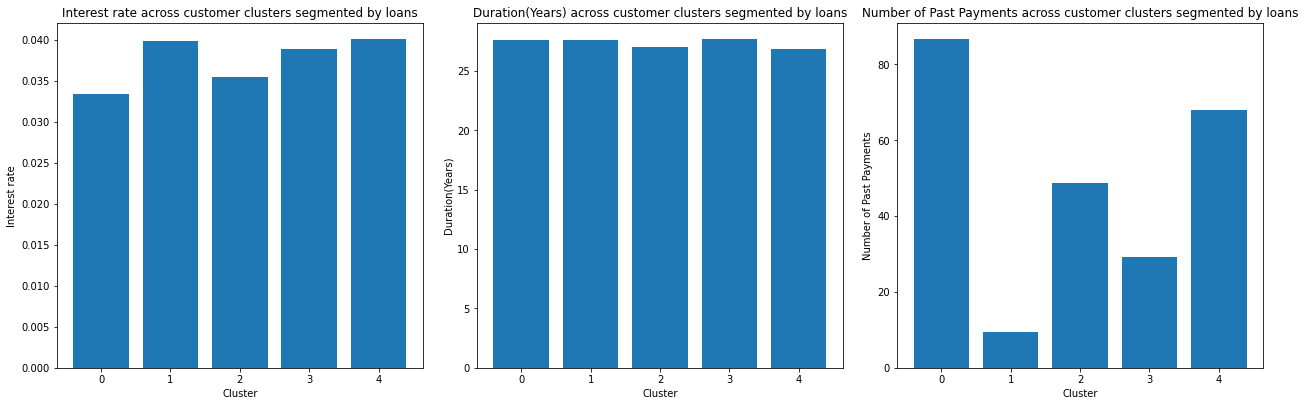

In [0]:
cluster_centers_df = pd.DataFrame(cluster_centers, columns=input_columns)
cluster_centers_spark_df = spark.createDataFrame(cluster_centers_df)
centers_pd_df = cluster_centers_spark_df.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ylabels = ["Interest rate","Duration(Years)","Number of Past Payments"]

for i, feature in enumerate(input_columns):
    axes[i].bar(centers_pd_df.index, centers_pd_df[feature])
    axes[i].set_title(f'{ylabels[i]} across customer clusters segmented by loans')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(ylabels[i])

fig.tight_layout(pad=2)
plt.show()

Risk Assessment

Before we look at the three visualizations, we have to remember that these clusters were made from the luxury loan porforlio dataframe, meaning it does not represent the trends of commoners. 
Looking at the three histograms, we can see that the duration of the 5 clusters are very similar, so it is not significant when doing risk assessment. The interests rates for the 5 clusters are also quite similar, the 0 cluster being below the others, followed by 2 cluster. The 1, 3, and 4 clusters have similar interest rates. 
Now, let's look at the most differentiating visualization: Number of Past Payments
There is a clear distinction of the number of payments between all 5 clusters, the order being 0 -> 4 -> 2 -> 3 -> 1 clusters from the greatest to the smallest. This order is also the order of the risky customer clusters because when the interest rate and the duration/number of past payments is high, the risk also increases. However, this is not the whole picture because a customer could have good credit score, meaning that they have been able to pay back loans even with high interest rates and durations. Therefore, more information about customers is needed before making a business decision. 


Additional Exploration of KPI: Loan Default Rate

In [0]:
# If loan status included information about default loans, we can find the Loan Default Rate with the code below.
default_loans_df = loans_df.filter(loans_df.status == "default")
total_loans_count = loans_df.count()
default_loans_count = default_loans_df.count()

loan_default_rate = (default_loans_count / total_loans_count) * 100